# Tutorial: Spatial clustering on 10x Visium (DLPFC dataset)

Here we present our re-analysis of 151675 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using RGAST.

DLPFC data can be downloaded from [SpatialLIBD](https://github.com/LieberInstitute/HumanPilot/). Extract and put data within data/DLPFC folder.
Please notice that the scale_factors_json.json and tissue_positions_list.csv can be found in 10X folder in SpatialLIBD.
For convenient, we have put three files within data folder here. You are recommended to make your folder structure like this:

In [ ]:
RGAST
 ├── data
   └── DLPFC
        └── 151675
              ├── filtered_feature_bc_matrix.h5
              ├── metadata.tsv 
              └── spatial
                     ├── scalefactors_json.json  
                     ├── tissue_positions_list.csv  
                     ├── full_image.tif  
                     ├── tissue_hires_image.png  
                     └── tissue_lowres_image.png  

## Preparation

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import RGAST
warnings.filterwarnings("ignore")
from sklearn.metrics.cluster import adjusted_rand_score

## read data

In [3]:
adata = sc.read_visium(path='../data/DLPFC/151675', count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

### read metadata

In [4]:
df_meta = pd.read_csv(f'../data/DLPFC/151673/metadata.tsv', sep='\t')
adata.obs = adata.obs.join(df_meta)

## preprocessing

In [5]:
#preprocess
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=200)

## Constructing gene expression similarity and spatial neighborhood relationships

In [6]:
RGAST.utils.Cal_Spatial_Net(adata)
RGAST.utils.Cal_Expression_Net(adata)

------Calculating spatial graph...
Spatial graph contains 21552 edges, 3592 cells.
6.0000 neighbors per cell on average.
------Calculating Expression simalarity graph...
Expression graph contains 23829 edges, 3592 cells.
6.6339 neighbors per cell on average.


## Model traininig

In [8]:
train_RGAST = RGAST.Train_RGAST(adata,dim_reduction='PCA',device_idx=0)
# with early stopping
# train_RGAST.train_RGAST(label_key="layer_guess",save_path='.',n_clusters=7)
# without early stopping
train_RGAST.train_RGAST(early_stopping=False, save_path='.', n_epochs=500)
train_RGAST.train_with_dec() #optional

Size of Input:  torch.Size([3592, 200])


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:23<00:00, 20.89it/s]


##  Clustering

In [10]:
from RGAST.utils import res_search_fixed_clus
n_clusters = 7
sc.pp.neighbors(adata, use_rep='RGAST')
_ = res_search_fixed_clus(adata, n_clusters)

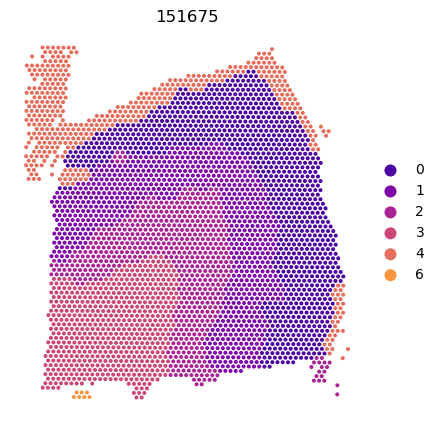

In [18]:
adata.obs['refine'] = RGAST.utils.refine_spatial_cluster(adata,adata.obs['RGAST']).astype(str) #optional
RGAST.utils.plot_clustering(adata, "refine",title='151675')

## Evaluation

In [21]:
obs_df = adata.obs.dropna(subset='layer_guess')
ARI = adjusted_rand_score(obs_df['refine'], obs_df['layer_guess'])
print('Adjusted rand index = %.3f' %ARI)

Adjusted rand index = 0.633
